# Crime Hotspot Detection - Clustering Validation

This notebook performs data validation and clustering readiness assessment for crime hotspot identification. It validates the presence of natural clusters in the data.

## Key Objectives
- Assess clustering tendency using Hopkins statistic
- Validate data integrity and completeness
- Ensure data is suitable for spatial-temporal hotspot analysis

**Note:**
- This notebook focuses on pre-clustering validation to ensure meaningful cluster analysis
- Statistical testing confirms data structure is suitable for hotspot detection

# Setup

Import essential libraries for data validation, clustering tendency assessment, and visualization.

## Google Drive Mount (optional)

If working locally, this cell can be ignored.

In [31]:
# from google.colab import drive
# drive.mount('/drive', force_remount=True)

### Import libraries

In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import List, Dict, Any, Tuple, Union
import time

# Data validation and clustering libraries
from scipy.stats import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Statistical testing
from scipy.stats import kstest, shapiro
from scipy.spatial.distance import pdist, squareform

import random

random.seed(42)
np.random.seed(42)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Libraries imported and random seeds set.")

Libraries imported and random seeds set.


## Path Definition

Define paths for loading the preprocessed crime dataset and saving validation results.

In [33]:
import os

base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "JupyterOutputs"))
feature_engineered_file_path = os.path.join(base_dir, "Final", "final_crime_data.csv")
save_dir = os.path.join(base_dir, "Clustering")
os.makedirs(save_dir, exist_ok=True)

print(f"Base directory: {base_dir}")
print(f"Feature engineered file path: {feature_engineered_file_path}")
print(f"Save directory: {save_dir}")

Base directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs
Feature engineered file path: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv
Save directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering


# Data Loading & Validation

Load the preprocessed crime dataset and perform initial validation of data integrity and completeness.

### Load and validate dataset

In [34]:
def load_and_validate_data(file_path: str) -> pd.DataFrame:
    """
    Load crime dataset and perform initial validation.
    
    Args:
        file_path: Path to the preprocessed crime data CSV file
        
    Returns:
        DataFrame: Loaded and validated crime data
    """
    print("=== Loading Crime Dataset ===")
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found at: {file_path}")
    
    df = pd.read_csv(file_path)
    print(f"Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")
    
    return df

# Load the dataset
df = load_and_validate_data(feature_engineered_file_path)

=== Loading Crime Dataset ===
Loaded data: 2493835 rows, 44 columns


### Data integrity assessment

In [35]:
print("=== Data Integrity Assessment ===")

# Basic data info
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumns: {df.columns.tolist()}")

# Data types overview
print("\n=== Data Types Overview ===")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count} columns")

# Missing values analysis
print("\n=== Missing Values Analysis ===")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    print(f"Columns with missing values: {len(missing_data)}")
    for col, missing_count in missing_data.head(10).items():
        missing_pct = (missing_count / len(df)) * 100
        print(f"  {col}: {missing_count} ({missing_pct:.2f}%)")
else:
    print("No missing values found in the dataset.")

# Duplicate rows check
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")

=== Data Integrity Assessment ===
Dataset shape: (2493835, 44)
Memory usage: 2453.35 MB

Columns: ['BORO_NM', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'METRO_DISTANCE', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE', 'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR', 'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY', 'SAME_AGE_GROUP', 'SAME_SEX', 'TO_CHECK_CITIZENS']

=== Data Types Overview ===
float64: 17 columns
object: 14 columns
int64: 13 columns

=== Missing Values Analysis ===
No missing values found in the dataset.

Duplicate rows: 0 (0.00%)


### Feature overview for clustering

In [36]:
print("=== Feature Overview for Clustering ===")

# Identify key feature categories for clustering analysis
spatial_features = ['Latitude', 'Longitude']
temporal_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'WEEKDAY', 'SEASON', 'TIME_BUCKET']
categorical_features = ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_RACE', 'VIC_SEX', 'VIC_AGE_GROUP']
numeric_features = [
    'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'METRO_DISTANCE',
    'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 
    'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE',
    'MAX_POI_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE'
]
binary_features = ['IS_WEEKEND', 'IS_HOLIDAY', 'IS_PAYDAY']

# Check which features are actually present
available_spatial = [f for f in spatial_features if f in df.columns]
available_temporal = [f for f in temporal_features if f in df.columns]
available_categorical = [f for f in categorical_features if f in df.columns]
available_numeric = [f for f in numeric_features if f in df.columns]
available_binary = [f for f in binary_features if f in df.columns]

print(f"Available spatial features ({len(available_spatial)}): {available_spatial}")
print(f"Available temporal features ({len(available_temporal)}): {available_temporal}")
print(f"Available categorical features ({len(available_categorical)}): {available_categorical}")
print(f"Available numeric features ({len(available_numeric)}): {available_numeric}")
print(f"Available binary features ({len(available_binary)}): {available_binary}")

# Basic statistics for key clustering features
if available_spatial:
    print("\n=== Spatial Features Statistics ===")
    print(df[available_spatial].describe())

if available_temporal:
    print("\n=== Temporal Features Statistics ===")
    print(df[available_temporal].describe())

=== Feature Overview for Clustering ===
Available spatial features (2): ['Latitude', 'Longitude']
Available temporal features (7): ['YEAR', 'MONTH', 'DAY', 'HOUR', 'WEEKDAY', 'SEASON', 'TIME_BUCKET']
Available categorical features (5): ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_RACE', 'VIC_SEX', 'VIC_AGE_GROUP']
Available numeric features (16): ['BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'METRO_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE']
Available binary features (3): ['IS_WEEKEND', 'IS_HOLIDAY', 'IS_PAYDAY']

=== Spatial Features Statistics ===
           Latitude     Longitude
count  2.493835e+06  2.493835e+06
mean   4.073690e+01 -7.392330e+01
std    8.232582e-02  7.717520e-02
min    4.049890e+01 -7.425474e+01
25%    4.067560e+01 -7.397269e+01
50%    4.073495e+01 -7.392570e+01
75%    4.081194e+01 

# Clustering Tendency Assessment

Assess whether the data contains natural clusters using Hopkins statistic and statistical testing. This validates that clustering analysis will be meaningful.

**Hopkins Statistic Interpretation:**
- H < 0.5: Data is uniformly distributed (no clustering tendency)
- H ≈ 0.5: Data is randomly distributed
- H > 0.75: Data has strong clustering tendency (suitable for cluster analysis)

### Hopkins Statistic Implementation

In [37]:
def hopkins_statistic(
    data: np.ndarray,
    sample_size: int = None,
    quantile_bounds: tuple[float, float] = (0.02, 0.98),
    random_state: int | None = 42
) -> float:
    """
    Robust calculation of the Hopkins statistic.

    Hopkins statistic measures the clustering tendency of a dataset:
        - ~0.5  → data is likely random (Poisson distribution)
        - ~0    → data is more uniform/regular
        - ~1    → data is highly clustered

    Improvements over the naive implementation:
        - Uses quantile bounds to reduce the impact of outliers
        - Ensures reproducibility with a random seed
        - Handles edge cases (very small sample sizes, degenerate ranges)

    Args:
        data (np.ndarray): Input dataset with shape (n_samples, n_features)
        sample_size (int, optional): Number of points to sample. 
                                     Default = min(n//10, 1000).
        quantile_bounds (tuple): Lower and upper quantiles for robust 
                                 bounding box (default: 2%-98%).
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        float: Hopkins statistic in [0, 1]. Returns NaN if undefined.
    """

    rng = np.random.default_rng(random_state)

    if data is None or len(data) < 3:
        return np.nan

    X = np.asarray(data, dtype=float)
    n, d = X.shape

    # Determine sample size
    if sample_size is None:
        sample_size = min(max(n // 10, 10), 1000)
    sample_size = min(sample_size, n - 1)
    if sample_size < 2:
        return np.nan

    # 1) Standardize data for stable distance computations
    scaler = StandardScaler()
    Xz = scaler.fit_transform(X)

    # 2) Normalize to [0,1]^d to define the bounding box
    mm = MinMaxScaler()
    Xu = mm.fit_transform(Xz)

    # 3) Use robust bounds (quantiles) instead of raw min–max
    q_low, q_high = quantile_bounds
    if not (0.0 <= q_low < q_high <= 1.0):
        raise ValueError("quantile_bounds must be within [0,1] with low < high")

    low = np.quantile(Xu, q_low, axis=0)
    high = np.quantile(Xu, q_high, axis=0)

    # Prevent zero-width ranges
    width = np.maximum(high - low, 1e-8)

    # 4) Sample real data points for U distances
    idx = rng.choice(n, size=sample_size, replace=False)
    sample_points = Xz[idx]

    # 5) Sample random points uniformly inside robust box,
    #    then map back to standardized space
    random_points_u = rng.random((sample_size, d)) * width + low
    z_min = mm.data_min_
    z_range = mm.data_range_
    random_points = random_points_u * z_range + z_min

    # 6) Nearest neighbors model on standardized data
    nbrs = NearestNeighbors(n_neighbors=2, metric="minkowski", p=2).fit(Xz)

    # U distances: from real sample points to their 2nd nearest neighbor
    u_dist, _ = nbrs.kneighbors(sample_points)
    u = u_dist[:, 1]

    # W distances: from random points to nearest neighbor in real data
    w_dist, _ = nbrs.kneighbors(random_points, n_neighbors=1)
    w = w_dist[:, 0]

    u_sum = float(np.sum(u))
    w_sum = float(np.sum(w))
    denom = u_sum + w_sum

    if denom <= 0:
        return np.nan

    return w_sum / denom

print("Hopkins statistic function defined.")

Hopkins statistic function defined.


### Spatial clustering tendency assessment

In [38]:
print("=== Spatial Clustering Tendency Assessment ===")

if available_spatial and len(df_clustering) > 100:
    # Extract spatial coordinates for Hopkins statistic
    spatial_data = df_clustering[available_spatial].values
    
    # Remove any remaining NaN values
    spatial_data_clean = spatial_data[~np.isnan(spatial_data).any(axis=1)]
    
    if len(spatial_data_clean) > 50:
        print(f"Computing Hopkins statistic on {len(spatial_data_clean)} spatial points...")
        
        # Calculate Hopkins statistic for spatial clustering tendency
        hopkins_spatial = hopkins_statistic(spatial_data_clean, sample_size=min(1000, len(spatial_data_clean)//10))
        
        print(f"\nSpatial Hopkins Statistic: {hopkins_spatial:.4f}")
        
        # Interpret the result
        if hopkins_spatial > 0.75:
            tendency = "Strong clustering tendency"
            recommendation = "Excellent for spatial hotspot detection"
        elif hopkins_spatial > 0.6:
            tendency = "Moderate clustering tendency" 
            recommendation = "Good for spatial hotspot detection"
        elif hopkins_spatial > 0.4:
            tendency = "Weak clustering tendency"
            recommendation = "May find some spatial patterns"
        else:
            tendency = "No clustering tendency (uniform/random)"
            recommendation = "Spatial clustering may not be meaningful"
            
        print(f"Interpretation: {tendency}")
        print(f"Recommendation: {recommendation}")
        
        # Statistical significance test
        print(f"\n=== Statistical Significance ===")
        print(f"Sample size used: {min(1000, len(spatial_data_clean)//10)}")
        print(f"Total spatial points: {len(spatial_data_clean)}")
        
        # Multiple Hopkins calculations for confidence estimation
        print(f"\nComputing confidence interval (5 iterations)...")
        hopkins_values = []
        for i in range(5):
            h_val = hopkins_statistic(spatial_data_clean, sample_size=min(500, len(spatial_data_clean)//20))
            if not np.isnan(h_val):
                hopkins_values.append(h_val)
                
        if hopkins_values:
            mean_hopkins = np.mean(hopkins_values)
            std_hopkins = np.std(hopkins_values) 
            
            print(f"Hopkins statistic: {mean_hopkins:.4f} ± {std_hopkins:.4f}")
            print(f"Range: [{min(hopkins_values):.4f}, {max(hopkins_values):.4f}]")
            
            # Final clustering recommendation
            if mean_hopkins > 0.75:
                print("\n✅ STRONG clustering tendency detected. Spatial hotspot analysis recommended.")
            elif mean_hopkins > 0.6:
                print("\n✅ MODERATE clustering tendency detected. Spatial clustering should work well.")
            elif mean_hopkins > 0.4:
                print("\n⚠️  WEAK clustering tendency detected. Results may be limited.")
            else:
                print("\n❌ NO clustering tendency detected. Consider data transformation or alternative methods.")
        else:
            print("Unable to compute confidence interval.")


=== Spatial Clustering Tendency Assessment ===
Computing Hopkins statistic on 2268128 spatial points...

Spatial Hopkins Statistic: 0.9998
Interpretation: Strong clustering tendency
Recommendation: Excellent for spatial hotspot detection

=== Statistical Significance ===
Sample size used: 1000
Total spatial points: 2268128

Computing confidence interval (5 iterations)...
Hopkins statistic: 0.9998 ± 0.0000
Range: [0.9998, 0.9998]

✅ STRONG clustering tendency detected. Spatial hotspot analysis recommended.


### Visual assessment of spatial distribution

=== Visual Assessment of Spatial Distribution ===
Visualizing sample of 10000 points (from 2268128 total)


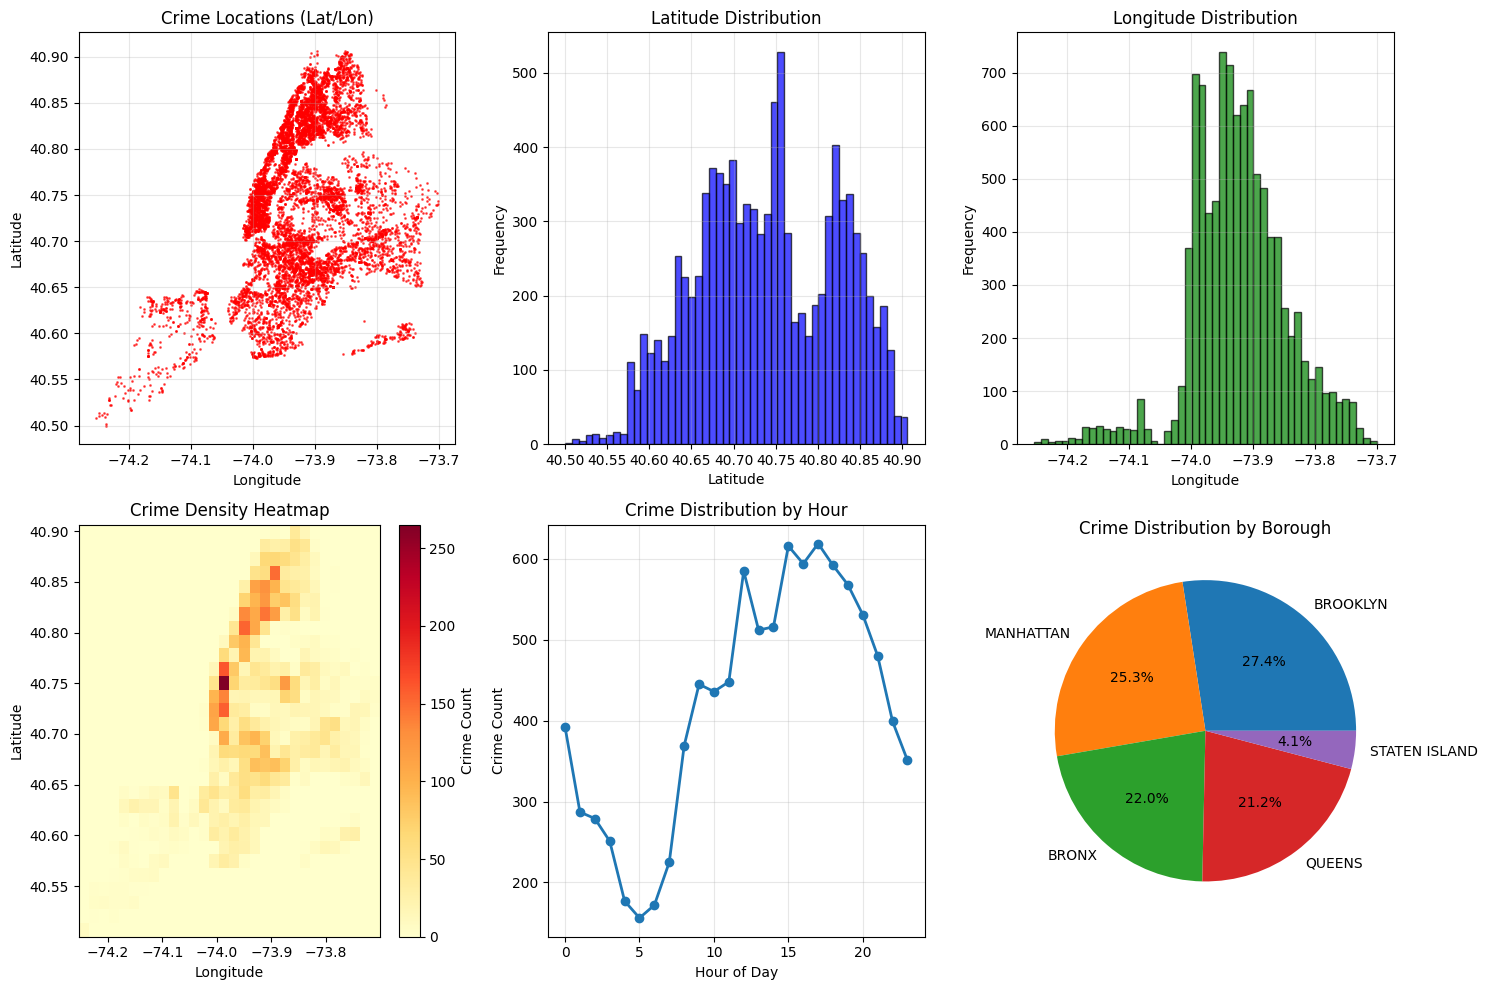


=== Spatial Statistics ===
Latitude range: 40.500044 to 40.906170
Longitude range: -74.253187 to -73.700717
Spatial center: (40.739050, -73.923731)
Spatial std: Lat=0.082066, Lon=0.076318

Potential spatial outliers: 0 latitude, 322 longitude


In [39]:
print("=== Visual Assessment of Spatial Distribution ===")

if available_spatial and len(df_clustering) > 0:
    # Create visualization plots for spatial distribution
    plt.figure(figsize=(15, 10))
    
    # Sample data for visualization if too large
    viz_sample_size = min(10000, len(df_clustering))
    if len(df_clustering) > viz_sample_size:
        df_viz = df_clustering.sample(n=viz_sample_size, random_state=42)
        print(f"Visualizing sample of {viz_sample_size} points (from {len(df_clustering)} total)")
    else:
        df_viz = df_clustering
        print(f"Visualizing all {len(df_viz)} points")
    
    # Subplot 1: Scatter plot of crime locations
    plt.subplot(2, 3, 1)
    plt.scatter(df_viz['Longitude'], df_viz['Latitude'], alpha=0.6, s=1, c='red')
    plt.title('Crime Locations (Lat/Lon)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Latitude distribution
    plt.subplot(2, 3, 2)
    plt.hist(df_viz['Latitude'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Latitude Distribution')
    plt.xlabel('Latitude')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Longitude distribution
    plt.subplot(2, 3, 3)
    plt.hist(df_viz['Longitude'], bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title('Longitude Distribution')
    plt.xlabel('Longitude')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: 2D histogram (heatmap)
    plt.subplot(2, 3, 4)
    plt.hist2d(df_viz['Longitude'], df_viz['Latitude'], bins=30, cmap='YlOrRd')
    plt.colorbar(label='Crime Count')
    plt.title('Crime Density Heatmap')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Subplot 5: Temporal distribution (if available)
    if 'HOUR' in df_viz.columns:
        plt.subplot(2, 3, 5)
        hourly_counts = df_viz['HOUR'].value_counts().sort_index()
        plt.plot(hourly_counts.index, hourly_counts.values, marker='o', linewidth=2)
        plt.title('Crime Distribution by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Crime Count')
        plt.grid(True, alpha=0.3)
    
    # Subplot 6: Borough distribution (if available)
    if 'BORO_NM' in df_viz.columns:
        plt.subplot(2, 3, 6)
        borough_counts = df_viz['BORO_NM'].value_counts()
        plt.pie(borough_counts.values, labels=borough_counts.index, autopct='%1.1f%%')
        plt.title('Crime Distribution by Borough')
    
    plt.tight_layout()
    plt.show()
    
    # Additional spatial statistics
    print("\n=== Spatial Statistics ===")
    print(f"Latitude range: {df_viz['Latitude'].min():.6f} to {df_viz['Latitude'].max():.6f}")
    print(f"Longitude range: {df_viz['Longitude'].min():.6f} to {df_viz['Longitude'].max():.6f}")
    print(f"Spatial center: ({df_viz['Latitude'].mean():.6f}, {df_viz['Longitude'].mean():.6f})")
    print(f"Spatial std: Lat={df_viz['Latitude'].std():.6f}, Lon={df_viz['Longitude'].std():.6f}")
    
    # Check for potential spatial outliers
    lat_q1, lat_q3 = df_viz['Latitude'].quantile([0.25, 0.75])
    lon_q1, lon_q3 = df_viz['Longitude'].quantile([0.25, 0.75])
    lat_iqr, lon_iqr = lat_q3 - lat_q1, lon_q3 - lon_q1
    
    lat_outliers = ((df_viz['Latitude'] < lat_q1 - 1.5*lat_iqr) | 
                   (df_viz['Latitude'] > lat_q3 + 1.5*lat_iqr)).sum()
    lon_outliers = ((df_viz['Longitude'] < lon_q1 - 1.5*lon_iqr) | 
                   (df_viz['Longitude'] > lon_q3 + 1.5*lon_iqr)).sum()
    
    print(f"\nPotential spatial outliers: {lat_outliers} latitude, {lon_outliers} longitude")
    
else:
    print("No spatial features available for visual assessment.")


### Statistical testing for uniformity

In [40]:
print("=== Statistical Testing for Uniformity ===")

if available_spatial and len(df_clustering) > 100:
    # Test if spatial coordinates deviate from uniform distribution
    print("Testing spatial coordinates against uniform distribution...")
    
    # Normalize coordinates to [0,1] range for uniformity testing
    lat_normalized = (df_clustering['Latitude'] - df_clustering['Latitude'].min()) / \
                     (df_clustering['Latitude'].max() - df_clustering['Latitude'].min())
    lon_normalized = (df_clustering['Longitude'] - df_clustering['Longitude'].min()) / \
                     (df_clustering['Longitude'].max() - df_clustering['Longitude'].min())
    
    # Kolmogorov-Smirnov test against uniform distribution
    ks_stat_lat, ks_p_lat = kstest(lat_normalized, 'uniform')
    ks_stat_lon, ks_p_lon = kstest(lon_normalized, 'uniform')
    
    print("\nKolmogorov-Smirnov Test Results:")
    print(f"Latitude: KS statistic = {ks_stat_lat:.4f}, p-value = {ks_p_lat:.2e}")
    print(f"Longitude: KS statistic = {ks_stat_lon:.4f}, p-value = {ks_p_lon:.2e}")
    
    alpha = 0.05
    if ks_p_lat < alpha:
        print(f"✅ Latitude significantly deviates from uniform distribution (p < {alpha})")
    else:
        print(f"❌ Latitude does not significantly deviate from uniform distribution (p >= {alpha})")
        
    if ks_p_lon < alpha:
        print(f"✅ Longitude significantly deviates from uniform distribution (p < {alpha})")
    else:
        print(f"❌ Longitude does not significantly deviate from uniform distribution (p >= {alpha})")
    
    # Additional test: Check for spatial concentration using variance
    print("\n=== Spatial Concentration Analysis ===")
    
    # Calculate coefficient of variation (CV) for spatial spread
    lat_cv = df_clustering['Latitude'].std() / abs(df_clustering['Latitude'].mean())
    lon_cv = df_clustering['Longitude'].std() / abs(df_clustering['Longitude'].mean())
    
    print("Coefficient of Variation:")
    print(f"Latitude CV: {lat_cv:.6f}")
    print(f"Longitude CV: {lon_cv:.6f}")
    
    # Test temporal distribution if available
    if 'HOUR' in df_clustering.columns:
        print("\n=== Temporal Distribution Testing ===")
        
        # Chi-square test for uniform temporal distribution
        from scipy.stats import chisquare
        
        hourly_counts = df_clustering['HOUR'].value_counts().sort_index()
        expected_freq = len(df_clustering) / 24  # Expected frequency for uniform distribution
        
        chi2_stat, chi2_p = chisquare(hourly_counts.values)
        
        print("Chi-square test for uniform hourly distribution:")
        print(f"Chi-square statistic: {chi2_stat:.4f}")
        print(f"p-value: {chi2_p:.2e}")
        
        if chi2_p < alpha:
            print(f"✅ Hourly distribution significantly deviates from uniform (p < {alpha})")
            print("   This suggests temporal clustering patterns exist")
        else:
            print(f"❌ Hourly distribution is approximately uniform (p >= {alpha})")
            
        # Show peak hours
        peak_hours = hourly_counts.nlargest(3)
        print("\nPeak crime hours:")
        for hour, count in peak_hours.items():
            print(f"  Hour {hour}: {count} crimes ({count/len(df_clustering)*100:.1f}%)")
            
else:
    print("Insufficient data for statistical testing.")

# Summary of clustering readiness
print(f"\n{'='*50}")
print("CLUSTERING READINESS SUMMARY")
print(f"{'='*50}")
print(f"Dataset size: {len(df_clustering)} records")
print(f"Spatial features: {available_spatial}")
print(f"Temporal features: {available_temporal}")
print(f"Ready for clustering analysis: {'✅ YES' if len(df_clustering) > 100 and available_spatial else '❌ NO'}")


=== Statistical Testing for Uniformity ===
Testing spatial coordinates against uniform distribution...

Kolmogorov-Smirnov Test Results:
Latitude: KS statistic = 0.2182, p-value = 0.00e+00
Longitude: KS statistic = 0.3828, p-value = 0.00e+00
✅ Latitude significantly deviates from uniform distribution (p < 0.05)
✅ Longitude significantly deviates from uniform distribution (p < 0.05)

=== Spatial Concentration Analysis ===
Coefficient of Variation:
Latitude CV: 0.002012
Longitude CV: 0.001038

=== Temporal Distribution Testing ===
Chi-square test for uniform hourly distribution:
Chi-square statistic: 289802.1621
p-value: 0.00e+00
✅ Hourly distribution significantly deviates from uniform (p < 0.05)
   This suggests temporal clustering patterns exist

Peak crime hours:
  Hour 15: 138142 crimes (6.1%)
  Hour 17: 137407 crimes (6.1%)
  Hour 16: 136374 crimes (6.0%)

CLUSTERING READINESS SUMMARY
Dataset size: 2268128 records
Spatial features: ['Latitude', 'Longitude']
Temporal features: ['YEA